# E-mail network analysis

## Mail Graph creation

### Importing the necessary packages
First of all we begin by importing the necessary packages. The necessary ones are `networkx` and `matplotlib.pyplot`. The first is used for network analysis and the second for plotting.

In [41]:
import networkx as nx  # Core network analysis package
import numpy as np  # Core numeric package
import matplotlib.pyplot as plt  # Core plotting package
import dzcnapy_plotlib as dzcnapy  # Optional library containing pre-made plotting options
import csv  # Package for csv I/O
from collections import Counter  # Import only the single object Counter

### Reading data files
We open the data in csv format (list of edges representing mail comunication) and create the corresponding **directed** graph, called `mail_DG`

In [42]:
with open("email-Eu-core.csv") as infile:
    csv_reader = csv.reader(infile)
    mail_DG = nx.DiGraph(csv_reader)

#print(DG.nodes(data = True))
#print(DG.edges(data = True))

Then we read the second file, which contains the department to which every node belongs, and add the information to the nodes in the graph. The result is a _directed graph_ with an attribute called `department` (with int values from 0 to 41) for each node.
There are 1005 nodes - or people - divided into 42 classes (or departments).

In [43]:
# We create a dictionary of dictionaries, having as key the node label (number between 0 and 1004)
# and with value a dictionary with the name of the attribute ('deprtment') as key and as associated value
# the department number of the node.
# NOTE: this structure is necessary because there could be more attributes, and it is required by the function
# set_node_attributes in networkx

with open("email-Eu-core-department-labels.csv") as infile:
    csv_reader = csv.reader(infile)
    attr_dict_dict = {rows[0]: {'department': int(rows[1])} for rows in csv_reader}

#print(attr_dict_dict)

In [44]:
nx.set_node_attributes(mail_DG, attr_dict_dict)

#print(DG.nodes(data = True))

###### Cleaning the graph
Let us remove the self-loops from the graph (sinche those represent the mail to one-self, irrelevant to the analysis):

In [51]:
self_loops = mail_DG.selfloop_edges()
mail_DG.remove_edges_from(self_loops)

We also create an undirected version of the graph, useful for some manipulation. This requires a simple casting.

In [52]:
mail_G = mail_DG.to_undirected()  # Undirected version of graph used for the computation of clustering coefficient

In [54]:
print("DIRECTED VERSION OF THE GRAPH:")
print(nx.info(mail_DG) + "\n")

print("UNDIRECTED VERSION:")
print(nx.info(mail_G))

DIRECTED VERSION OF THE GRAPH:
Name: 
Type: DiGraph
Number of nodes: 1005
Number of edges: 24929
Average in degree:  24.8050
Average out degree:  24.8050

UNDIRECTED VERSION:
Name: 
Type: Graph
Number of nodes: 1005
Number of edges: 16064
Average degree:  31.9682


## Department graph creation
The analysis of the department graph (based on the interactions between their elements) could be of interest.
We create the graph by adding all departments as nodes, and then adding edges between them based on the number of (undirected) edges between their elements.

In [55]:
# Graph initialization with just the departments as nodes

dep_G = nx.Graph()
for node in mail_DG.nodes(data = True):
    label, attr_dict = node
    dep_G.add_node(attr_dict["department"])
    
#print(nx.info(dep_G))

In [56]:
# For each edge in the undirected mail graph, identify the department of bot source and target
# and create an edge between those departments in the departments graph if not already existing.
# Otherwise add a weight unit to the existing edge between departments.
for edge in mail_G.edges(data=True):
    source, target, edg_attr = edge
    source_dep = attr_dict_dict[source]['department']
    targ_dep = attr_dict_dict[target]['department']
    if dep_G.has_edge(source_dep, targ_dep) == False:
        dep_G.add_edge(source_dep, targ_dep, weight = 1)
    else:
        edges = dep_G.edges
        w = edges[source_dep, targ_dep]['weight']
        dep_G.add_edge(source_dep, targ_dep, weight = w+1)

Note that the result is an undirected weighted graph with 42 nodes:

In [57]:
print(nx.info(dep_G))

Name: 
Type: Graph
Number of nodes: 42
Number of edges: 679
Average degree:  32.3333


### Graph export
To visualize the graphs, we export them in `graphml` format to import them in _Gephi_.

In [58]:
nx.write_graphml(mail_DG, "emails_w_attr_dep.graphml")
nx.write_graphml(dep_G, "departments_weighted.graphml")

## Networks Analysis

### Connected components and Giant Component
#### Mail network
First, we analyze the composition of the network by searching for the weakly and strongly connected components in the directed mail graph.
Note that, clearly, the number of weakly connected components of the directed mail graph is the same as the number of connected components of the undirected mail graph.

In [59]:
n_weak_conn_comp = nx.number_weakly_connected_components(mail_DG)
n_strong_conn_comp = nx.number_strongly_connected_components(mail_DG)
n_conn_comp = nx.number_connected_components(mail_G)

print("# of connected components: " + str(n_conn_comp))
print("# of weakly connected components: " + str(n_weak_conn_comp))
print("# of strongly connected components: " + str(n_strong_conn_comp))

# of connected components: 20
# of weakly connected components: 20
# of strongly connected components: 203


Is there a giant component in the graph?

In [60]:
# Create the list of components (subgraphs)
connected_components_generator = (mail_DG.subgraph(c) for c in nx.connected_components(mail_G))
conn_comp_list = list(connected_components_generator)

# Compute total size and order to see the proportion in the components
tot_nodes_n = mail_DG.order()
tot_directed_edges_n = mail_DG.size()
tot_undirected_edges_n = mail_G.size()

# Initialize variables to search for the biggest component:
max_order = 0
max_order_index = 0

# Scan through components, find the one with max order and print some info for the first bunch
for (i, component) in zip(range(len(conn_comp_list)), conn_comp_list):
    n_nodes_comp = component.order()
    n_directed_edges_comp = component.size()   
    
    if n_nodes_comp > max_order:
        max_order = n_nodes_comp
        max_order_index = i
    
    relative_order = n_nodes_comp/tot_nodes_n
    relative_size = n_directed_edges_comp/tot_directed_edges_n
    
    if i < 3:
        print("COMPONENT #" + str(i) + ":")
        print("# of nodes: " + str(n_nodes_comp))
        print("# of edges: " + str(n_directed_edges_comp))
        print("Relative Order (proportion of nodes):", relative_order)
        print("Relative Size (proportion of edges):", relative_size)
        print()

print("...")

COMPONENT #0:
# of nodes: 986
# of edges: 24929
Relative Order (proportion of nodes): 0.981094527363184
Relative Size (proportion of edges): 1.0

COMPONENT #1:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

COMPONENT #2:
# of nodes: 1
# of edges: 0
Relative Order (proportion of nodes): 0.0009950248756218905
Relative Size (proportion of edges): 0.0

...


Yes.
The other 19 components are actually isolated nodes that communicate at most with themselves (self-loops).

In [61]:
giant_component_mail_DG = conn_comp_list[0]
gc_mail_DG = giant_component_mail_DG

For the analysis of the mail network, we can in some instances use just the giant component. This will enable us to find measures like distances without risking to find infinite-length (not connected) paths.

### Measures - degree

# TODO

In [62]:
print("density of email network:", str(nx.density(mail_DG)))
print("density of department network:", str(nx.density(dep_G)))

density of email network: 0.024706150522288955
density of department network: 0.7886178861788617


In [63]:
nx.average_clustering(mail_G)

0.3993549664221539

In [15]:
central_node = 160
CC_dict = nx.clustering(G)
CC = sum(CC_dict.values())/len(CC_dict.values())
print("CC:", CC)

cc_central_node = nx.clustering(G, str(central_node))
betweenness = nx.betweenness_centrality(DG, normalized = False)
print("clustering coefficient:", str(cc_central_node))
print("betweenness of nodes:", str(betweenness))
type(betweenness)

CC: 0.3993549664221539
clustering coefficient: 0.09351196494775868
betweenness of nodes: {'0': 1548.732711772583, '1': 0.0, '2': 5850.7025488610425, '3': 1536.6856003944515, '4': 5232.020213445737, '5': 27174.02169102858, '6': 12722.776976944997, '7': 2976.6751760880616, '8': 755.45847187551, '9': 480.9143252228849, '10': 1185.073644948173, '11': 5115.525290375631, '12': 4559.996036798694, '13': 10873.680857997577, '14': 3381.010243515185, '15': 2192.226766772277, '16': 1140.9271440771845, '17': 4840.115652338846, '18': 2294.2477558039745, '19': 4228.629105042066, '20': 3585.665765959523, '21': 12738.096111006318, '22': 89.06728288294357, '23': 2977.717640849257, '24': 1172.1837811519179, '25': 235.98248946056705, '26': 119.69785687742731, '27': 1832.727676076164, '28': 5519.884862107221, '29': 1285.8029855889947, '30': 2187.141178130908, '31': 441.63159145567505, '32': 121.79567320987869, '33': 142.80670385976273, '34': 146.49204694946988, '35': 1669.5858221132892, '36': 228.642393668

dict

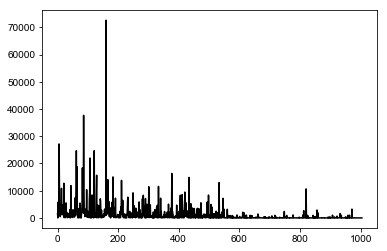

In [16]:
lis = []
for key in betweenness.keys():
    lis.append(betweenness[key])

plt.plot(range(len(lis)), lis)

In [17]:
print("betweenness of departments:", str(nx.betweenness_centrality(DG_only_dep, normalized = False)))

betweenness of departments: {1: 10.190677776183604, 21: 8.357407430021457, 25: 4.638564501090789, 14: 6.467265077770905, 9: 5.283051647582242, 26: 12.021258306764135, 4: 45.23643002445134, 17: 1.9643378536985068, 34: 10.190677776183604, 11: 4.716423836077672, 5: 0.8561535179054752, 10: 10.49740209761381, 36: 18.32401110951694, 37: 8.161065340688815, 7: 6.644448676479272, 22: 3.328023220967801, 8: 6.383421688169675, 15: 16.044671005176838, 3: 0.063894523326572, 29: 0.6350262796043239, 20: 1.4588673768119576, 16: 0.8528909672516203, 38: 8.80646434599494, 27: 0.6541513393699301, 13: 3.6974020976138062, 6: 3.549941731734722, 0: 1.4259789903396434, 28: 2.6135722976192213, 2: 1.3353157916947003, 40: 2.5965002412478912, 35: 6.467265077770905, 23: 1.9350864023289869, 19: 5.33839449247591, 24: 0.2975606909430438, 32: 1.371053756740273, 31: 0.09637605042016806, 39: 0.28983928719703245, 12: 0.1421630874572051, 30: 0.06696428571428571, 41: 0.0, 18: 0.0, 33: 0.0}


[('0', 73), ('1', 52), ('2', 161), ('3', 118), ('4', 163), ('5', 280), ('6', 202), ('7', 116), ('8', 62), ('9', 60), ('10', 75), ('11', 134), ('12', 96), ('13', 233), ('14', 128), ('15', 82), ('16', 115), ('17', 167), ('18', 88), ('19', 120), ('20', 118), ('21', 240), ('22', 27), ('23', 132), ('24', 63), ('25', 50), ('26', 53), ('27', 96), ('28', 174), ('29', 94), ('30', 112), ('31', 82), ('32', 55), ('33', 43), ('34', 49), ('35', 97), ('36', 63), ('37', 54), ('38', 70), ('39', 49), ('40', 101), ('41', 140), ('42', 117), ('43', 19), ('44', 175), ('45', 76), ('46', 117), ('47', 84), ('48', 97), ('49', 23), ('50', 27), ('51', 110), ('52', 42), ('53', 58), ('54', 90), ('55', 71), ('56', 80), ('57', 114), ('58', 218), ('59', 90), ('60', 91), ('61', 118), ('62', 369), ('63', 218), ('64', 249), ('65', 124), ('66', 46), ('67', 15), ('68', 79), ('69', 101), ('70', 28), ('71', 29), ('72', 12), ('73', 54), ('74', 158), ('75', 32), ('76', 37), ('77', 35), ('78', 23), ('79', 70), ('80', 119), ('81

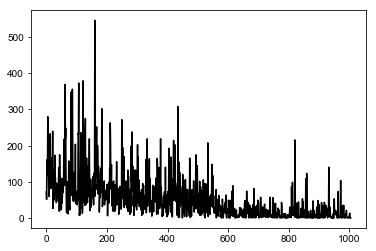

In [18]:
print(nx.degree(DG))
lis2 = []

for x, y in nx.degree(DG):
    lis2.append(y)

plt.plot(range(len(lis2)), lis2)

Counter({1: 71, 2: 48, 4: 33, 3: 31, 7: 26, 6: 23, 8: 21, 5: 18, 32: 15, 11: 15, 49: 14, 15: 14, 37: 14, 14: 14, 36: 14, 28: 13, 27: 12, 31: 12, 16: 12, 54: 11, 19: 11, 40: 11, 20: 11, 43: 10, 23: 10, 46: 10, 12: 10, 25: 10, 41: 10, 17: 10, 58: 9, 79: 9, 44: 9, 10: 9, 22: 9, 60: 8, 50: 8, 80: 8, 9: 8, 62: 7, 63: 7, 74: 7, 59: 7, 30: 7, 82: 6, 88: 6, 42: 6, 124: 6, 29: 6, 35: 6, 45: 6, 64: 6, 38: 6, 13: 6, 75: 5, 96: 5, 53: 5, 76: 5, 110: 5, 90: 5, 48: 5, 83: 5, 67: 5, 99: 5, 39: 5, 24: 5, 47: 5, 33: 5, 18: 5, 26: 5, 73: 4, 118: 4, 97: 4, 91: 4, 77: 4, 68: 4, 21: 4, 69: 4, 133: 4, 103: 4, 57: 4, 34: 4, 52: 3, 116: 3, 94: 3, 55: 3, 70: 3, 117: 3, 84: 3, 114: 3, 56: 3, 144: 3, 66: 3, 219: 3, 86: 3, 108: 3, 61: 3, 51: 3, 141: 3, 87: 3, 163: 2, 112: 2, 101: 2, 140: 2, 175: 2, 71: 2, 218: 2, 234: 2, 127: 2, 166: 2, 93: 2, 193: 2, 169: 2, 85: 2, 138: 2, 72: 2, 107: 2, 170: 2, 102: 2, 203: 2, 106: 2, 111: 2, 65: 2, 104: 2, 161: 1, 280: 1, 202: 1, 134: 1, 233: 1, 128: 1, 115: 1, 167: 1, 120: 1,

/Users/claudio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: RuntimeWarning: divide by zero encountered in log
  


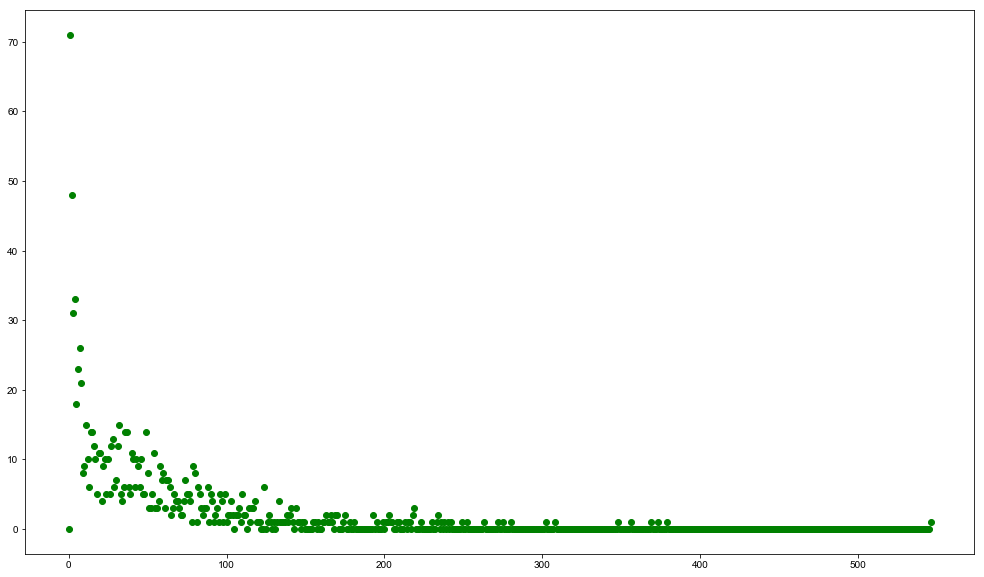

In [19]:
counter = Counter(lis2)
#count, _ = np.histogram(lis2, bins=15)
print(counter)

max_degree = max(counter.keys())
print(max_degree)
degrees_freq = np.zeros(max_degree+1)
print(degrees_freq)
for i in range(max_degree+1):
    degrees_freq[i] = counter[i]

print(degrees_freq)
log_degrees_freq = np.log(degrees_freq)

plt.figure(1, figsize=(17, 10))

axes = plt.gca()
#axes.set_xlim([0, 14])
#axes.set_ylim([0, 8])

#plt.plot(count)
degrees = np.arange(0, max_degree+1)
plt.scatter(degrees, degrees_freq, color = 'green')
plt.savefig("degree_distribution.png")

/Users/claudio/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: RuntimeWarning: divide by zero encountered in log
  """


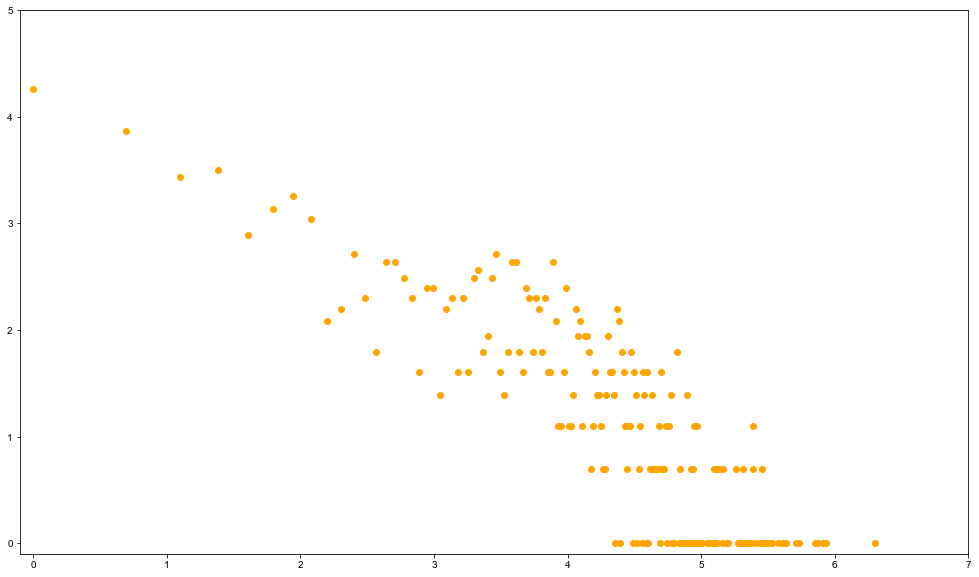

In [20]:
plt.figure(1, figsize=(17, 10))
axes = plt.gca()
axes.set_xlim([-0.10, 7])
axes.set_ylim([-0.1, 5])
plt.scatter(np.log(degrees), np.log(degrees_freq), color= 'orange')
plt.savefig("log_log_degree.png")

In [49]:
lista = nx.degree(DG)
assortativity = np.zeros(len(degrees))
avg_neighbor_deg = nx.average_neighbor_degree(DG)
for i in range(1, len(assortativity)):
    avg = 0
    num = 0
    summ = 0
    for node_str, degree in lista:
        if degree == i:
            num += 1
            summ += avg_neighbor_deg[node_str]
    avg = summ/num if num is not 0 else 0
    assortativity[i] = avg

print(assortativity)

[  0.           9.4084507   15.4375      18.51612903  22.66161616
  21.41666667  25.96014493  33.57371795  27.1984127   41.75208333
  45.73888889  51.89507937  49.7922619   52.29761905  69.43755927
  74.32219388  53.98244048  41.04527778  51.29880952  54.89134855
  38.22914207  24.59583333  59.25096262  50.10276557  50.41083333
  45.69030012  58.6459482   53.32059746  60.77278157  47.38980862
  55.54908782  49.47867804  49.8726602   43.68246965  69.40078807
  55.69913313  56.90392429  49.28448097  57.19501532  42.55763975
  53.39238638  57.4341882   55.69773269  47.00103333  62.13503197
  60.10509378  55.71664392  77.15098105  54.40018908  56.79792536
  65.7231891   57.89512661  24.98024425  53.56787982  54.16211056
  62.95150502  48.78504736  71.63452381  56.76509114  67.11381591
  54.82802986  61.0614192   59.81576757  52.54692549  44.91564435  58.625
  52.14344344  56.30044581  56.95432861  67.42433488  52.65319396
  60.33415033  54.75909091  50.24253451  64.9931313   55.87610357
  

0.00551416613716


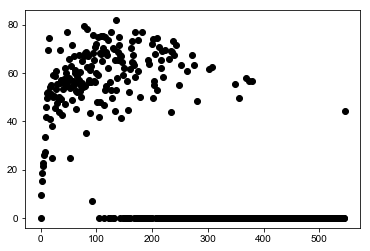

In [58]:
print(nx.degree_assortativity_coefficient(DG))
plt.scatter(range(len(assortativity)), assortativity)

In [21]:
max_distance = 0
max_source = 0
for source, dictionary in nx.shortest_path_length(G):
    max_distance = max(dictionary.values()) if max(dictionary.values()) > max_distance else max_distance
    max_source = int(source) if int(source) > max_source else int(source)

print(max_distance)
print(max_source)

7
1004


In [22]:
distances = np.zeros(max_distance+1)
sources = np.arange(max_source+1)

for source, dictionary in nx.shortest_path_length(G):
    key = 0
    while key < int(source):
        if str(key) in dictionary:
            del dictionary[str(key)]
        key = key + 1
    count = Counter(dictionary.values())
    for i in range(max_distance+1):
        distances[i] = distances[i] + count[i]

print(distances)

[  1.00500000e+03   1.60640000e+04   2.07601000e+05   2.25070000e+05
   3.46900000e+04   2.08900000e+03   9.00000000e+01   1.00000000e+00]


2.5815910071720678

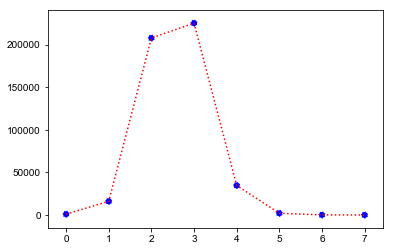

In [23]:
plt.plot(distances, linestyle='dotted', color = 'red')
plt.scatter(range(len(distances)), distances, linestyle='dotted', color = 'blue')
plt.savefig("distance_distribution.png")
tot_distances = sum(distances)
weighted_sum = 0
for i in range(len(distances)):
    weighted_sum += i*distances[i]

average_distance = weighted_sum/tot_distances
average_distance

Name: 
Type: SubDiGraph
Number of nodes: 986
Number of edges: 25552
Average in degree:  25.9148
Average out degree:  25.9148


In [29]:
nx.average_shortest_path_length(largest_cc)

2.164486568301397

In [33]:
nx.diameter(largest_cc.to_undirected())

7

In [34]:
nx.radius(largest_cc.to_undirected())

4

In [37]:
eccentricities = nx.eccentricity(largest_cc.to_undirected())
eccentricities

{'96': 4,
 '898': 6,
 '239': 5,
 '649': 5,
 '352': 4,
 '729': 5,
 '779': 5,
 '683': 5,
 '969': 6,
 '213': 5,
 '187': 5,
 '398': 5,
 '145': 4,
 '259': 5,
 '186': 5,
 '484': 5,
 '472': 5,
 '458': 4,
 '690': 5,
 '978': 5,
 '205': 4,
 '112': 5,
 '314': 4,
 '465': 5,
 '499': 5,
 '510': 5,
 '423': 4,
 '540': 5,
 '378': 4,
 '774': 6,
 '446': 5,
 '868': 5,
 '851': 5,
 '414': 5,
 '117': 5,
 '287': 5,
 '82': 4,
 '483': 4,
 '280': 4,
 '768': 5,
 '848': 5,
 '532': 5,
 '871': 5,
 '737': 6,
 '550': 5,
 '874': 5,
 '67': 5,
 '654': 5,
 '682': 5,
 '793': 5,
 '743': 6,
 '570': 5,
 '42': 5,
 '671': 5,
 '214': 4,
 '8': 5,
 '796': 5,
 '795': 5,
 '516': 5,
 '147': 4,
 '31': 5,
 '228': 4,
 '815': 5,
 '944': 5,
 '615': 4,
 '202': 5,
 '973': 6,
 '27': 4,
 '346': 4,
 '451': 5,
 '98': 5,
 '948': 5,
 '912': 5,
 '441': 5,
 '777': 5,
 '919': 4,
 '349': 4,
 '938': 6,
 '749': 5,
 '106': 4,
 '708': 5,
 '281': 5,
 '611': 5,
 '133': 4,
 '665': 5,
 '59': 5,
 '591': 5,
 '625': 6,
 '436': 5,
 '473': 4,
 '599': 5,
 '780': 5

In [39]:
min(eccentricities.values())

4

In [38]:
print(eccentricities[str(central_node)])

4
